<a href="https://colab.research.google.com/github/Rudrabha/SS2021-19-08-2021/blob/main/Image_Super_Resolve_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

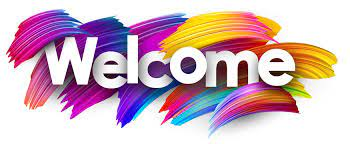

**Import Headers**

General Headers

In [25]:
import os
!pip install wget
import wget
import shutil
import glob
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


PyTorch based Headers

In [26]:
from torch.utils.data import Dataset, DataLoader
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim

**SETTING UP THE DEVICE FOR GPU COMPUTATION**

1. Cuda : For faster computation using GPU
2. CPU : For normal computations
3. nvidia-smi : To check the GPU unit

In [27]:
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)
!nvidia-smi

use_cuda: True
Device to be used :  cuda
Sat Jul 23 10:12:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |   2870MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

**Setting up Data Path**

In [28]:
#shutil.rmtree("/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data")

In [29]:
#PARENT PROJECT FOLDER
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"

if os.path.isdir(parent_folder):
    shutil.rmtree(parent_folder)
os.mkdir(parent_folder)

#FOLDER FOR DOWNLOADING RAW DATA AND EXTRACTING IT
raw_data_folder = os.path.join(parent_folder,"raw_data")
extracted_data_folder = os.path.join(parent_folder,"extracted_data")

if not os.path.isdir(raw_data_folder):
    os.mkdir(raw_data_folder)

if not os.path.isdir(extracted_data_folder):
    os.mkdir(extracted_data_folder)
    
#PATH TO THE IMAGE FOLDER
image_data_folder = os.path.join(extracted_data_folder, "images")

**Downloading Data**

In [30]:
#DATASET LINK TO OXFORD-IIIT PET DATASET
dataset_link = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
raw_data = os.path.join(raw_data_folder, "images.tar.gz")

#DOWNLOADING THE DATA USING wget MODULE
print("Downloading Data")
wget.download(dataset_link, raw_data)
print("Downloading Done")

**Extracting the Data**

In [31]:
#EXTRACTING USING SHUTIL
shutil.unpack_archive(raw_data, extracted_data_folder)

**Function to Remove None Images**
1. I/P : Path to Image Data Folder
2. O/P : Path to all the images

In [32]:
def get_image_address(image_data_folder):
    image_address_list = []
    image_address_list = glob.glob(os.path.join(image_data_folder, "*.jpg"))
    print("Number of Files : ", len(image_address_list))
    for img_addr in image_address_list:
        try :
            img = cv2.imread(img_addr)
            x = img.shape
        except :
            image_address_list.remove(img_addr)
            os.remove(img_addr)
        
    print("Number of Files after removing : ", len(image_address_list))

    return image_address_list

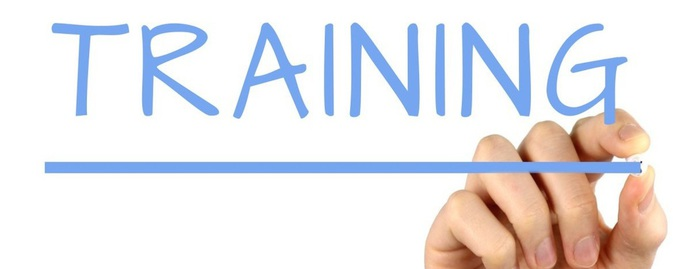

**START OF TRAINING MODULE**

1. Module 1 : Data Loader
2. Module 2 : Model Creation
3. Module 3 : Training
4. Module 4 : Inference

**MODULE_1 : Data Loader**

In [33]:
class DataGenerator(Dataset):
	
    def __init__(self, image_list):
        self.files = image_list[:10]
        #ONLY 10 FILES ARE CHOSEN TO SHOW THE RESULT
        #self.files = image_list
        

    #NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)
        

    #GETTING SINGLE PAIR OF DATA
    def __getitem__(self,idx):

        #print(files[idx])
        img = cv2.imread(self.files[idx])
        high_res_img = cv2.resize(img,(512,512))
        high_res_img = np.transpose(high_res_img, (2, 0, 1))
        low_res_img = cv2.resize(img,(64,64))
        low_res_img = cv2.resize(low_res_img, (512, 512))
        low_res_img = np.transpose(low_res_img, (2, 0, 1))
        return torch.FloatTensor(high_res_img/255.), torch.FloatTensor(low_res_img/255.)
		
	
def load_data(image_list, batch_size=32, num_workers=10, shuffle=True):

    dataset = DataGenerator(image_list)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return data_loader

**Checking the dataloader : DISPLAYING SAMPLES**

In [34]:
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
extracted_data_folder = os.path.join(parent_folder, "extracted_data")
image_data_folder = os.path.join(extracted_data_folder, "images")
image_address_list = get_image_address(image_data_folder)
random.shuffle(image_address_list)

train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
train_loader = load_data(train_img_addr_list, batch_size=1, num_workers=2, shuffle=True)
check = iter(train_loader)



Number of Files :  7390
Number of Files after removing :  7384


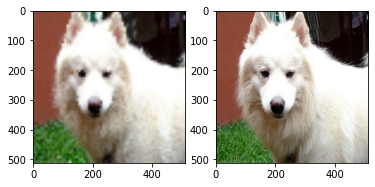

In [35]:
GT, input_img = next(check)
input_img = input_img.numpy()[0]
GT = GT.numpy()[0]

input_img = np.transpose(input_img, (1, 2, 0))
GT = np.transpose(GT, (1, 2, 0))

input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
GT = cv2.cvtColor(GT, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(input_img)
axarr[1].imshow(GT)

**MODULE 2 : Model Creation**

**Conv2D : Convolution Class with added Functionalities, like Batch Norm and Residual**

In [36]:
class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

**Conv2D-Transpose : Transpose Convolution Class with added Functionalities, like Batch Norm and Residual**

In [37]:
class Conv2dTranspose(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

**Model : JOINING THE ABOVE CREATED BLOCKS**

Encoder Decoder Architecture

In [38]:
class Image_Super_Resolve(nn.Module):
    def __init__(self):
        super(Image_Super_Resolve, self).__init__()

        self.image_encoder = nn.Sequential(
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),      
            )
        self.image_decoder = nn.Sequential(

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(3, 3, 1, 1, 0)
            )
        
    def forward(self, face_image):

        #print("Shape : ",face_image.shape)
        face_embedding = self.image_encoder(face_image)
        # print("Shape : ",face_embedding.shape)
        decoded_face = self.image_decoder(face_embedding)
        decoded_face = decoded_face + face_image

        decoded_face = torch.sigmoid(decoded_face)
        # print("Shape : ",decoded_face.shape)
        return decoded_face


**Code to check the model shape**

In [39]:
model = Image_Super_Resolve()
data = torch.rand(2, 3, 512, 512)
print(data.shape)
decoded_data = model.forward(data)
print (decoded_data.shape)

torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])


**LOSS FUNCTION : PEAK SIGNAL TO NOISE RATIO**

In [40]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))


**MODULE 3 : Training**

**SAVE CHECKPOINT**

In [41]:
def save_ckp(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)

**LOAD CHECKPOINT**

In [42]:
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']

**TRAIN EPOCH**

In [43]:
def train_epoch(train_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:
      # if high_res_img is None and low_res_img is None:
      #     continue
      model.train()
      
      #TRANSFERRING DATA TO DEVICE
      high_res_img = high_res_img.to(device)
      low_res_img = low_res_img.to(device)

      optimizer.zero_grad()

      #GETTING THE PREDICTED IMAGE
      pred_img = model.forward(low_res_img)

      #LOSS FUNCTIONS
      mse = nn.MSELoss()
      l1 = nn.L1Loss()
      psnr = PSNR()

      #CALCULATING LOSSES
      mse_loss = mse(pred_img, high_res_img)
      l1_loss = l1(pred_img, high_res_img)
      psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

      #LOSS TAKEN INTO CONSIDERATION
      loss = mse_loss
      #PSNR CAN ALSO BE TAKEN OR A LINEAR COMBINATION OF THEM

      # print(loss)

      #BACKPROPAGATING THE LOSS
      loss.backward()
      optimizer.step()

      #DISPLAYING THE LOSS
      progress_bar.set_description(
      "Epoch : {} Training Loss : {} ".format(epoch, loss))


    return model, optimizer

**VAL EPOCH**

In [44]:
def val_epoch(val_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:

        try :
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()
            pred_img = model.forward(low_res_img)

            mse_loss = mse(pred_img, high_res_img)
            l1_loss = l1(pred_img, high_res_img)
            psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

            loss = mse_loss

            progress_bar.set_description(
            "Epoch : {} Validation Loss : {} ".format(epoch-1, loss))
        except :
            continue


**TEST EPOCH**

In [45]:
def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 10

    #FOLDER PATH TO WRITE THE INFERENCES
    inference_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/inference_data"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    if not os.path.isdir(os.path.join(inference_folder, str(epoch))):
        os.mkdir(os.path.join(inference_folder, str(epoch)))

    for step, (high_res_img, low_res_img) in progress_bar:

        try:
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()

            #PREDICTED IMAGE
            pred_img = model.forward(low_res_img)

            #mse_loss = mse(pred_img, high_res_img)
            #psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)
            l1_loss = l1(pred_img, high_res_img)

            loss = l1_loss

            progress_bar.set_description(
            "Epoch : {} Test Loss : {} ".format(epoch-1, loss))

            #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
            if(step < no_img_to_write):

                p_img = pred_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                gt_img = high_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255

                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_pred.jpg"), p_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_gt.jpg"), gt_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_inp.jpg"), inp_img[0])
        except :
            continue

**Code to control the Train, Test & Val**

In [46]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "/content/IMAGE_SUPER_RESOLVE_DATA/checkpoint.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while 1:
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)
        
        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        
        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

        #CHECKPOINT LOADING
        model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)
            test_epoch(test_loader, model, optimizer, epoch)

**MAIN FUNCTION**

In [47]:
def main():

    parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
    extracted_data_folder = os.path.join(parent_folder, "extracted_data")
    image_data_folder = os.path.join(extracted_data_folder, "images")
    image_address_list = get_image_address(image_data_folder)
    random.shuffle(image_address_list)

    train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
    val_img_addr_list = image_address_list[len(train_img_addr_list):int(
        len(train_img_addr_list) + 0.2*len(image_address_list))]
    test_img_addr_list = image_address_list[len(
        train_img_addr_list) + len(val_img_addr_list):]

    print("Total Number of Images : ", len(image_address_list))
    print("Train : {} Val : {} Test : {}".format(
        len(train_img_addr_list), len(val_img_addr_list), len(test_img_addr_list)))

    #CREATING THE TRAIN LOADER
    train_loader = load_data(
        train_img_addr_list, batch_size=2, num_workers=2, shuffle=True)
    
    #CREATING THE VALIDATION LOADER
    val_loader = load_data(val_img_addr_list, batch_size=2,
                           num_workers=2, shuffle=True)
    
    #CREATING THE TEST LOADER
    test_loader = load_data(
        test_img_addr_list, batch_size=1, num_workers=2, shuffle=False)

    #CALLING THE MODEL
    model = Image_Super_Resolve()
    
    #UPLOADING THE MODEL TO DEVICE
    model = model.to(device)

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
    
    n_epoch = 100
    
    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    train_val_test(train_loader, val_loader, test_loader,
                   model, optimizer, n_epoch, resume)

**CALLING THE MAIN FUNCTION**

In [ ]:
main()

Number of Files :  7384


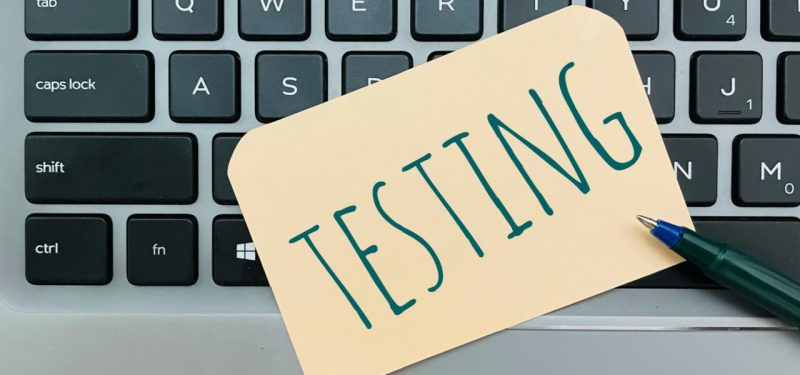

**Module 4 : Inference**

In [ ]:
image_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data/images"
checkpoint_path = "/content/IMAGE_SUPER_RESOLVE_DATA/checkpoint.pt"

#PARTICULAR IMAGE
img_addr = os.path.join(image_folder, "Abyssinian_2.jpg")
img = cv2.imread(img_addr)
high_res_img = cv2.resize(img,(512,512))
low_res_img = cv2.resize(img,(64,64))
low_res_img = cv2.resize(low_res_img, (512, 512))
low_res_img = np.transpose(low_res_img, (2, 0, 1))

#CONVERTING TO FLOAT TENSOR AND INCREASE ITS DIMENSION
low_res_img = torch.FloatTensor(low_res_img/255.).unsqueeze(0)


model = Image_Super_Resolve()
model = model.to(device)
optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
low_res_img = low_res_img.to(device)
pred_img = model.forward(low_res_img)

p_img = pred_img.detach().cpu().numpy().transpose(0, 2, 3, 1)
# p_img = cv2.cvtColor(p_img, )
inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1)

#DISPLAYING THE GROUND TRUTH
print("Ground Truth")
plt.imshow(high_res_img[:,:,::-1])
plt.show()

#DISPLAYING THE INPUT IMAGE
print("Input Image")
plt.imshow(inp_img[0, :,:,::-1])
plt.show()

#DISPLAYING THE PREDICTED IMAGE
print("Predicted Image")
plt.imshow(p_img[0, :,:,::-1])
plt.show()

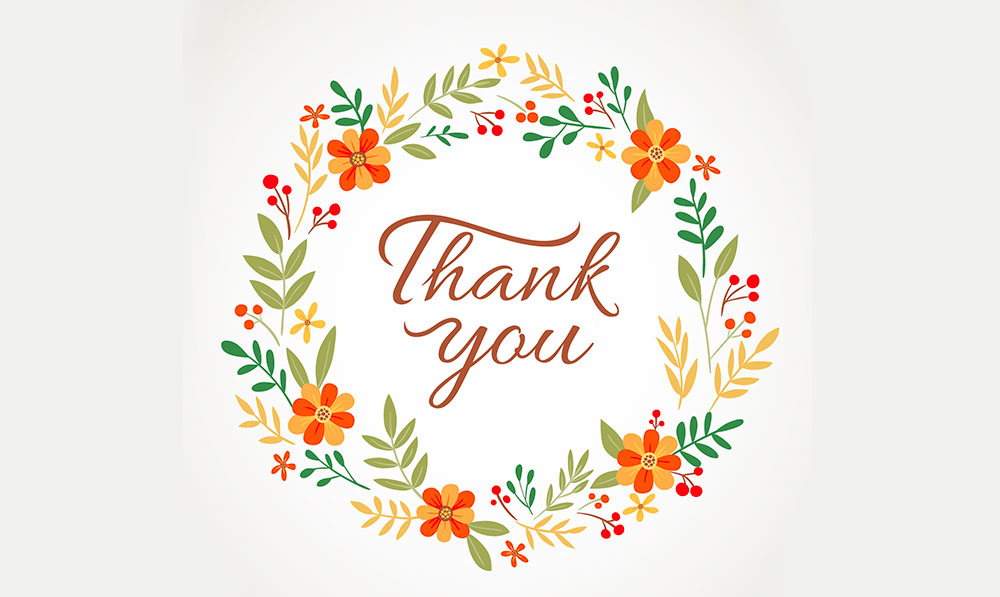